In [1]:
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.linear_model import LinearRegression, Lasso, Ridge, RANSACRegressor, HuberRegressor
from sklearn.svm import SVR
from sklearn.model_selection import KFold, train_test_split, GridSearchCV
from sklearn.metrics import  precision_recall_fscore_support, root_mean_squared_error
import seaborn as sns
from prettytable import prettytable
import librosa
import os
from tqdm import tqdm
from sklearn.preprocessing import OneHotEncoder
import gdown
from zipfile import ZipFile as extract_zip

In [2]:
file_url = "https://drive.google.com/uc?id=1FcWrBIg63MwV26DE0882baBarakUb3HA"
gdown.download(file_url, "DSL_Winter_Project_2025.zip", quiet=False)

Downloading...
From (original): https://drive.google.com/uc?id=1FcWrBIg63MwV26DE0882baBarakUb3HA
From (redirected): https://drive.google.com/uc?id=1FcWrBIg63MwV26DE0882baBarakUb3HA&confirm=t&uuid=566b8720-5e51-42f9-b907-f636fea745a7
To: c:\Users\Claudio\Desktop\Projects\DSL_Winter_Project_2025\DSL_Winter_Project_2025.zip
100%|██████████| 1.24G/1.24G [02:18<00:00, 8.93MB/s]


'DSL_Winter_Project_2025.zip'

In [3]:
with extract_zip("./DSL_Winter_Project_2025.zip") as num:
    num.extractall(".")

In [4]:
complete_dev_df= pd.read_csv("DSL_Winter_Project_2025/development.csv", index_col=False)
complete_eval_df= pd.read_csv("DSL_Winter_Project_2025/evaluation.csv", index_col=False)

In [5]:
complete_dev_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2933 entries, 0 to 2932
Data columns (total 20 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Id                      2933 non-null   int64  
 1   sampling_rate           2933 non-null   int64  
 2   age                     2933 non-null   float64
 3   gender                  2933 non-null   object 
 4   ethnicity               2933 non-null   object 
 5   mean_pitch              2933 non-null   float64
 6   max_pitch               2933 non-null   float64
 7   min_pitch               2933 non-null   float64
 8   jitter                  2933 non-null   float64
 9   shimmer                 2933 non-null   float64
 10  energy                  2933 non-null   float64
 11  zcr_mean                2933 non-null   float64
 12  spectral_centroid_mean  2933 non-null   float64
 13  tempo                   2933 non-null   object 
 14  hnr                     2933 non-null   

In [6]:
def preprocessing(df):
    df_=df.drop(columns=["Id","ethnicity", "path"], inplace=False)
    df_["tempo"] = df_["tempo"].apply(lambda x: float(x.strip("[]")))
    df_["gender"] = np.where(df_["gender"]=="male", 0,1)
    return df_

In [7]:
dev_df = preprocessing(complete_dev_df)
eval_df = preprocessing(complete_eval_df)

In [8]:
def split_df(df, col):
    X=df.drop(columns=[col], inplace=False)
    y= df[col]
    return X, y

In [9]:
X, y_train= split_df(dev_df, "age")

In [10]:
def correlation_matrix(df):
    plt.figure(figsize=(6,6))
    correlation = df.corr()
    sns.heatmap(correlation, annot=False, cmap="coolwarm")
    plt.show()

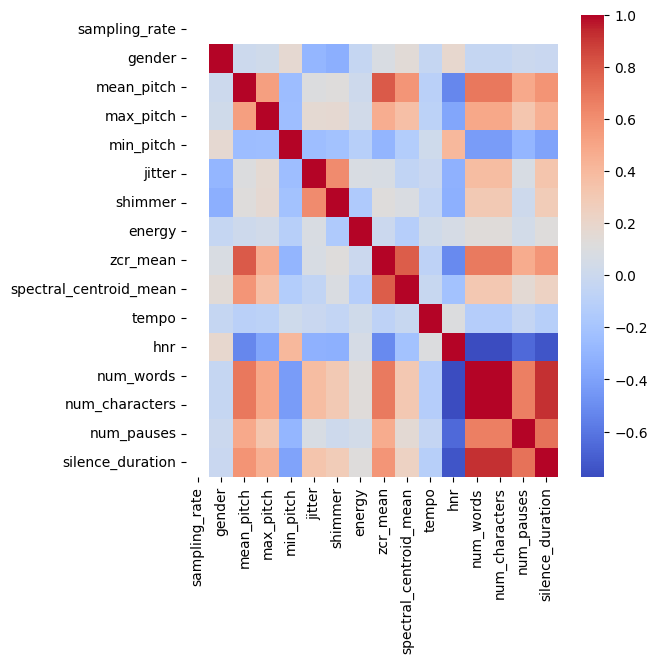

In [11]:
correlation_matrix(X)

In [12]:
def extract_features(file_name):
    y, sr = librosa.load(file_name)
    spectrogram = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=40)
    log_spectrogram = librosa.power_to_db(spectrogram, ref=np.max)
    avg=np.mean(log_spectrogram) # Mean across time
    std= np.std(log_spectrogram) # Standard deviation across time
    spectral_bandwidth = np.mean(librosa.feature.spectral_bandwidth(y=y, sr=sr))
    spectral_contrast = np.mean(librosa.feature.spectral_contrast(y=y, sr=sr))
    spectral_flatness = np.mean(librosa.feature.spectral_flatness(y=y))
    spectral_rolloff = np.mean(librosa.feature.spectral_rolloff(y=y, sr=sr))
    mfcc = np.mean(librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13))
    delta_mfcc = np.mean(librosa.feature.delta(librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13)))
    chroma = np.mean(librosa.feature.chroma_stft(y=y, sr=sr))
    
    return {
        "mean_spectrogram": avg,
        "std_spectrogram": std,
        "spectral_bandwidth": spectral_bandwidth,
        "spectral_contrast": spectral_contrast,
        "spectral_flatness": spectral_flatness,
        "spectral_rolloff": spectral_rolloff,
        "mfcc": mfcc,
        "delta_mfcc": delta_mfcc,
        "chroma": chroma
    }

In [13]:
def add_features(df, audio_folder):
    audio_df= pd.DataFrame(columns=["mean_spectrogram","std_spectrogram","spectral_bandwidth","spectral_contrast","spectral_flatness","spectral_rolloff", "mfcc", "delta_mfcc","chroma"])

    # Lista per raccogliere le feature
    rows = []

    # Estrai le feature per ogni file
    for file_name in tqdm(os.listdir(audio_folder)):
        file_path = os.path.join(audio_folder, file_name)
        if os.path.isfile(file_path):  # Controlla che sia un file
            features = extract_features(file_path)
            rows.append(features)

    # Crea il DataFrame in un'unica operazione
    audio_df = pd.DataFrame(rows)
    
    total_df = pd.concat((df, audio_df),axis=1)
    return total_df

In [14]:
X_train = add_features(X, "DSL_Winter_Project_2025/audios_development")

100%|██████████| 2933/2933 [13:12<00:00,  3.70it/s]


In [15]:
X_train.to_csv("X_train.csv", index=False)

In [16]:
X_test = add_features(eval_df, "DSL_Winter_Project_2025/audios_evaluation")

100%|██████████| 691/691 [03:38<00:00,  3.17it/s]


In [17]:
X_train.to_csv("X_test.csv", index=False)

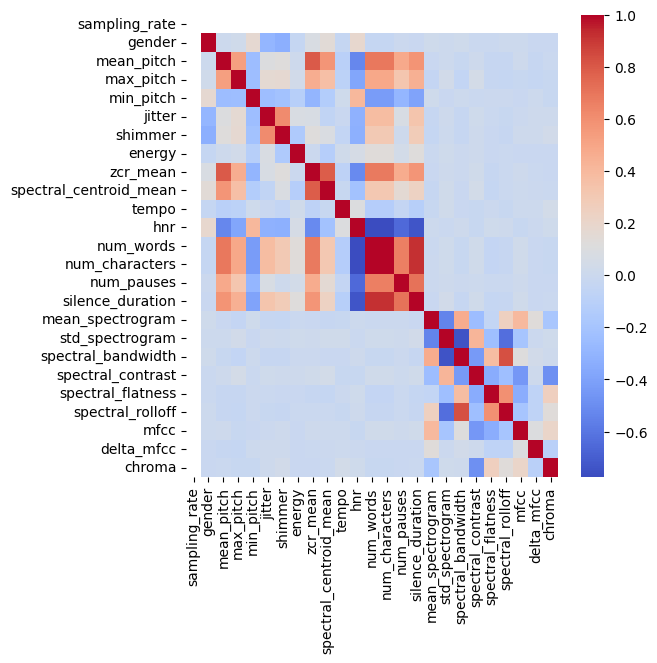

In [18]:
correlation_matrix(X_train)

In [19]:
X_train.drop(columns=["num_words"], inplace=True)

In [20]:
X_test.drop(columns=["num_words"], inplace=True)

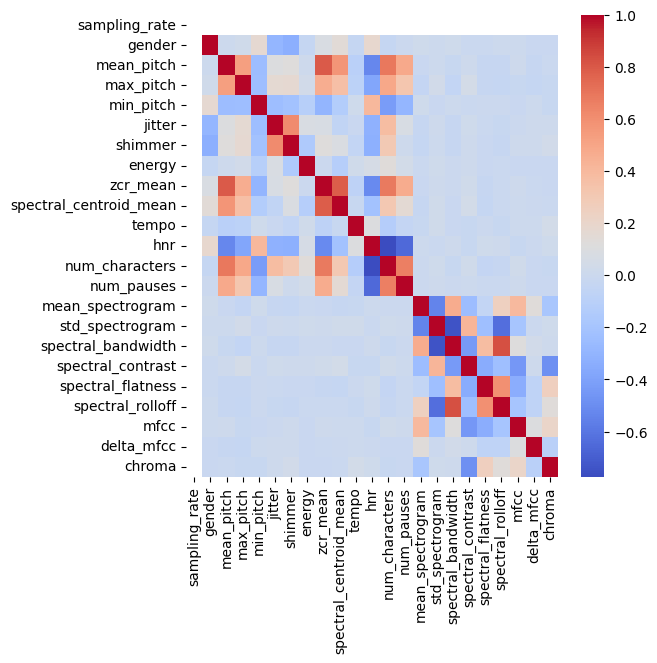

In [21]:
correlation_matrix(X_train)

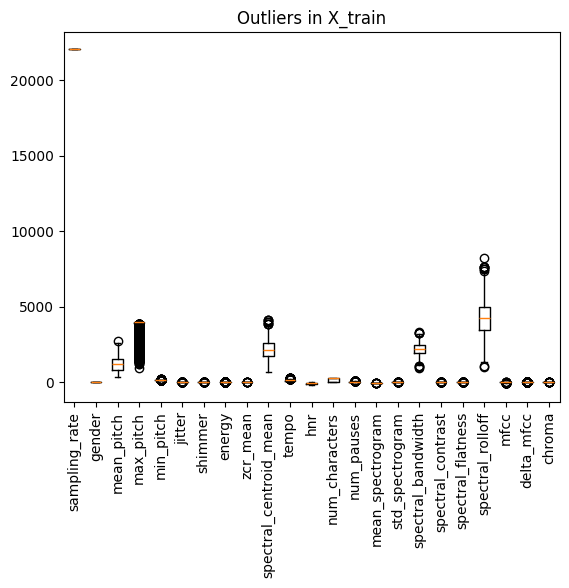

In [22]:
plt.subplot()
plt.boxplot(X_train[X_train.columns], tick_labels=X_train.columns)
plt.xticks(rotation=90)
plt.title("Outliers in X_train")
plt.show()

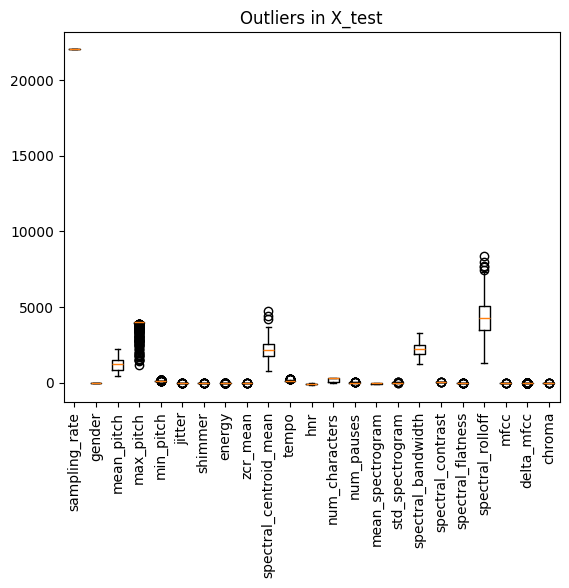

In [23]:
plt.subplot()
plt.boxplot(X_test[X_test.columns], tick_labels=X_test.columns)
plt.xticks(rotation=90)
plt.title("Outliers in X_test")
plt.show()

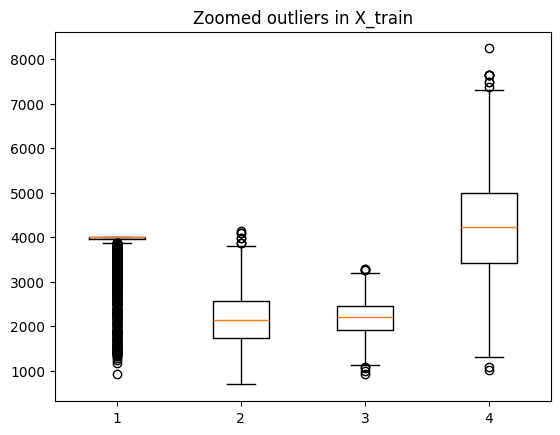

In [24]:
plt.subplot()
plt.boxplot(X_train[[ 'max_pitch', "spectral_centroid_mean","spectral_bandwidth" ,'spectral_rolloff']])
plt.title("Zoomed outliers in X_train")
plt.show()

In [25]:
std=StandardScaler()
mm=MinMaxScaler()
X_std=pd.DataFrame(std.fit_transform(X_train), columns=X_train.columns)
X_mm=pd.DataFrame(mm.fit_transform(X_train), columns=X_train.columns)

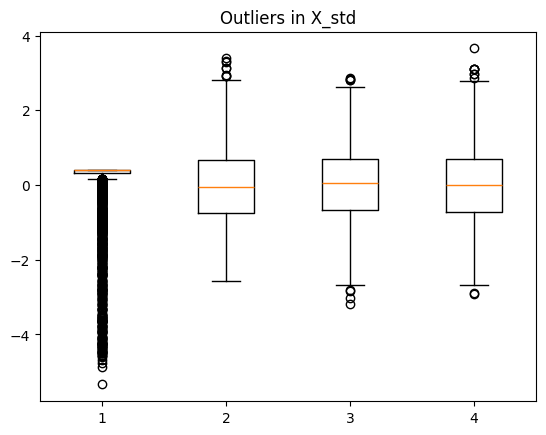

In [26]:
plt.subplot()
plt.boxplot(X_std[[ 'max_pitch', "spectral_centroid_mean","spectral_bandwidth" ,'spectral_rolloff']])
plt.title("Outliers in X_std")
plt.show()

In [27]:
# Calculate the IQR for the max_pitch column
Q1 = X_train['max_pitch'].quantile(0.25)
Q3 = X_train['max_pitch'].quantile(0.75)

IQR = Q3 - Q1
# Determine the lower and upper bounds

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR
# Count the number of outliers

outliers = (X_train['max_pitch'] < lower_bound) | (X_train['max_pitch'] > upper_bound)
X_train= X_train[~outliers]
y_train= y_train[~outliers]

In [28]:
# Calculate the IQR for the max_pitch column
Q1 = X_std['max_pitch'].quantile(0.25)
Q3 = X_std['max_pitch'].quantile(0.75)

IQR = Q3 - Q1
# Determine the lower and upper bounds

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR
# Count the number of outliers

outliers = (X_std['max_pitch'] < lower_bound) | (X_std['max_pitch'] > upper_bound)
X_train_std= X_std[~outliers]
y_train_std= y_train[~outliers]

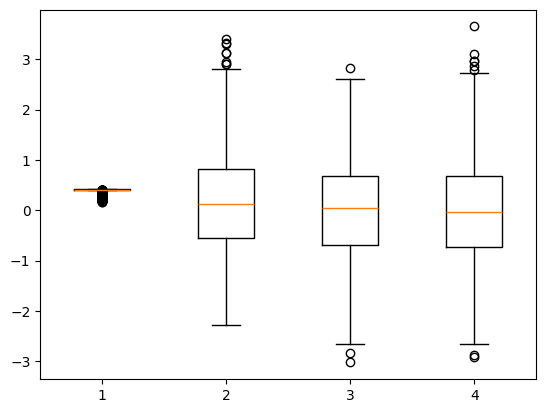

In [29]:
plt.subplot()
plt.boxplot(X_train_std[[ 'max_pitch', "spectral_centroid_mean","spectral_bandwidth" ,'spectral_rolloff']])
plt.show()

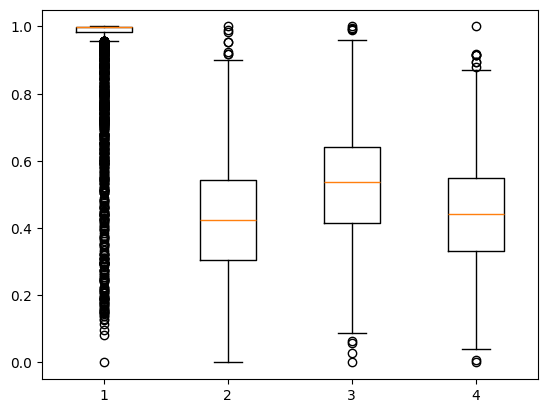

In [30]:
plt.subplot()
plt.boxplot(X_mm[[ 'max_pitch', "spectral_centroid_mean","spectral_bandwidth" ,'spectral_rolloff']])
plt.show()

In [31]:
# Calculate the IQR for the max_pitch column
Q1 = X_mm['max_pitch'].quantile(0.25)
Q3 = X_mm['max_pitch'].quantile(0.75)

IQR = Q3 - Q1
# Determine the lower and upper bounds

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR
# Count the number of outliers

outliers = (X_mm['max_pitch'] < lower_bound) | (X_mm['max_pitch'] > upper_bound)
X_train_mm= X_mm[~outliers]
y_train_mm= y_train[~outliers]

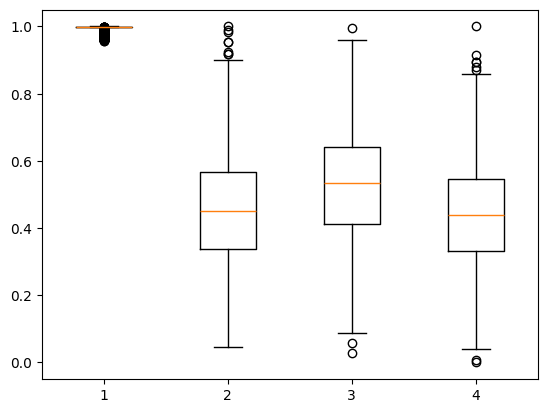

In [32]:
plt.subplot()
plt.boxplot(X_train_mm[[ 'max_pitch', "spectral_centroid_mean","spectral_bandwidth" ,'spectral_rolloff']])
plt.show()

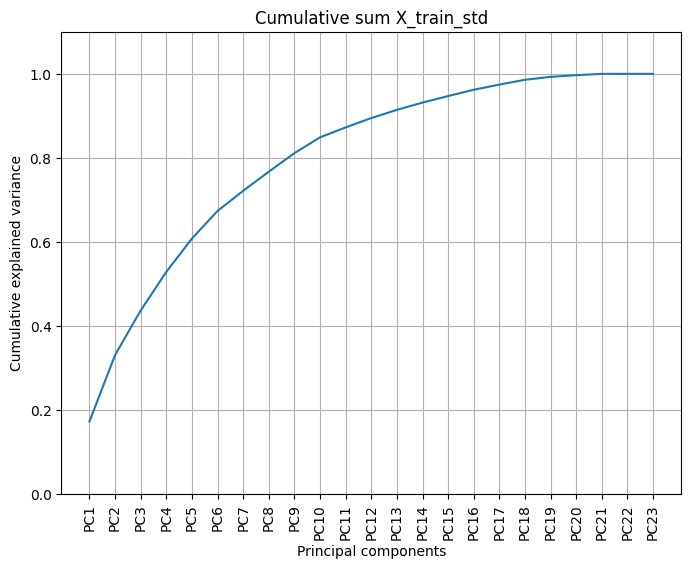

In [33]:
pca= PCA()
pca.fit(X_train_std.values)

round_expl_var_ratio = np.round(pca.explained_variance_ratio_.sum()*100,decimals=2)  # <-- TODO!!

plt.figure(figsize=(8,6))
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.title('Cumulative sum X_train_std')
plt.ylim([0, 1.1])
plt.xticks(ticks=np.arange(pca.n_features_in_), 
           labels=[f'PC{i + 1}' for i in range(pca.n_features_in_)],
           rotation=90)
plt.xlabel('Principal components')
plt.ylabel('Cumulative explained variance')
plt.ylim()
plt.grid()
plt.show()

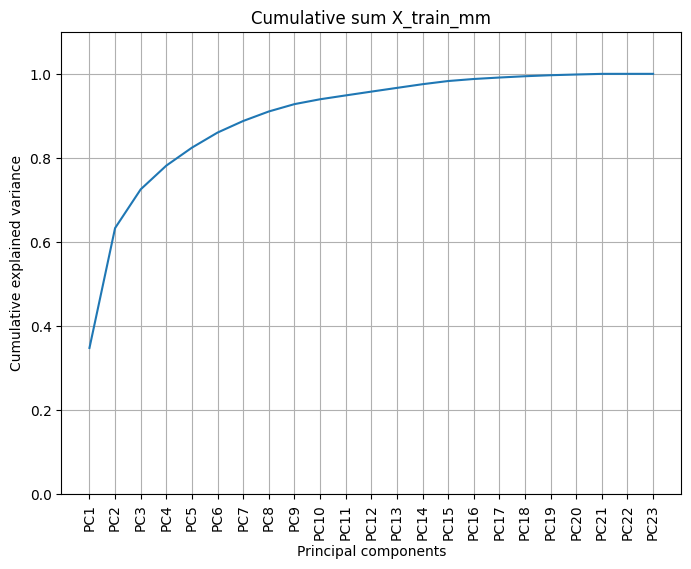

In [34]:
pca= PCA()
pca.fit(X_train_mm.values)

round_expl_var_ratio = np.round(pca.explained_variance_ratio_.sum()*100,decimals=2)  # <-- TODO!!

plt.figure(figsize=(8,6))
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.title('Cumulative sum X_train_mm')
plt.ylim([0, 1.1])
plt.xticks(ticks=np.arange(pca.n_features_in_), 
           labels=[f'PC{i + 1}' for i in range(pca.n_features_in_)],
           rotation=90)
plt.xlabel('Principal components')
plt.ylabel('Cumulative explained variance')
plt.ylim()
plt.grid()
plt.show()

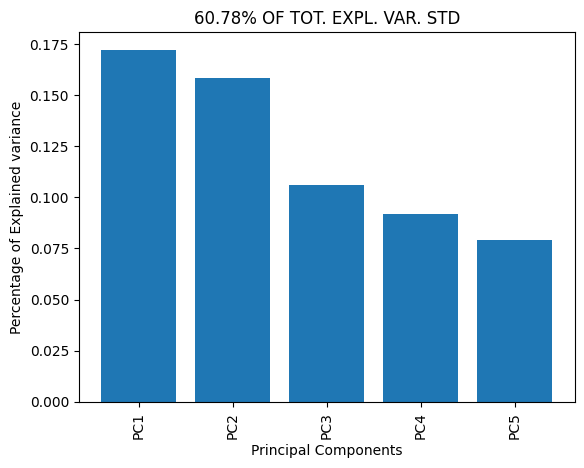

In [35]:
m=5
pca_std = PCA(n_components=m)
pca_std.fit(X_train_std)  
round_expl_var_ratio = np.round(pca_std.explained_variance_ratio_.sum()*100,decimals=2)

plt.figure()
plt.bar(range(1,m+1), pca_std.explained_variance_ratio_)
plt.title(f"{round_expl_var_ratio}% OF TOT. EXPL. VAR. STD")
plt.xticks(ticks=np.arange(1,m+1), 
           labels=[f"PC{i}" for i in range(1,m+1)],
           rotation=90)
plt.xlabel("Principal Components")
plt.ylabel("Percentage of Explained variance")
plt.show()

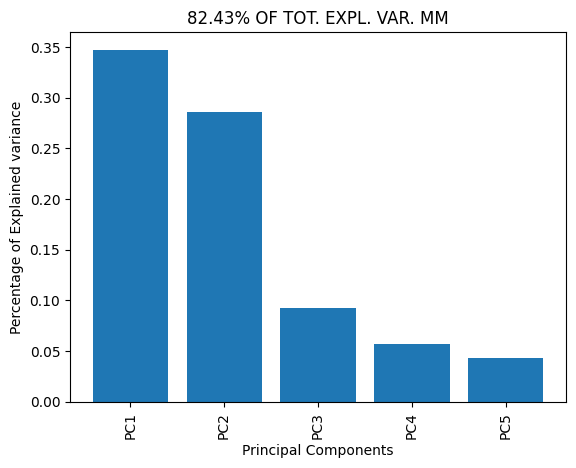

In [36]:
m= 5
pca_std = PCA(n_components=m)
pca_std.fit(X_train_mm)  
round_expl_var_ratio = np.round(pca_std.explained_variance_ratio_.sum()*100,decimals=2)

plt.figure()
plt.bar(range(1,m+1), pca_std.explained_variance_ratio_)
plt.title(f"{round_expl_var_ratio}% OF TOT. EXPL. VAR. MM")
plt.xticks(ticks=np.arange(1,m+1), 
           labels=[f"PC{i}" for i in range(1,m+1)],
           rotation=90)
plt.xlabel("Principal Components")
plt.ylabel("Percentage of Explained variance")
plt.show()

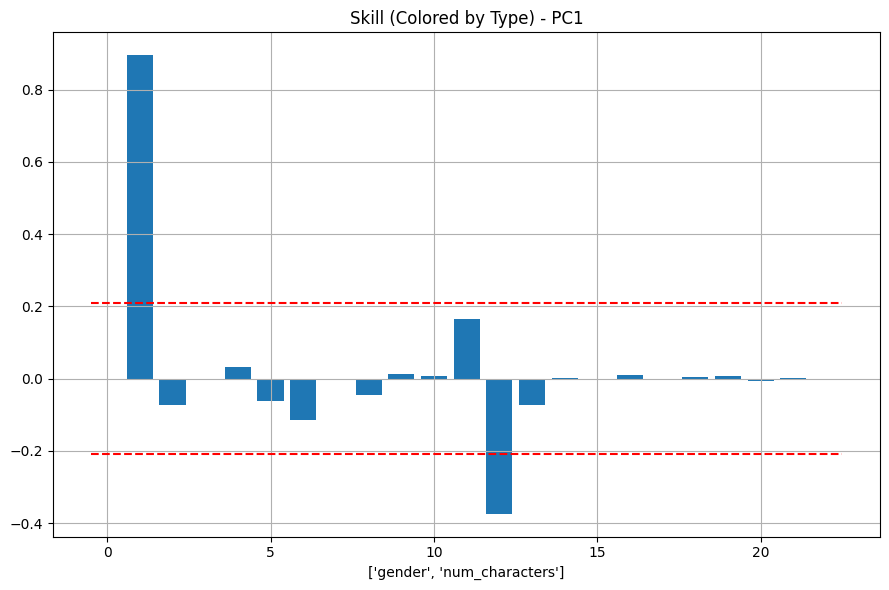


****************** PC1 **********************
HIGH-VALUED POSITIVE COMPONENTS: ['gender']

HIGH-VALUED NEGATIVE COMPONENTS: ['num_characters']
*********************************************



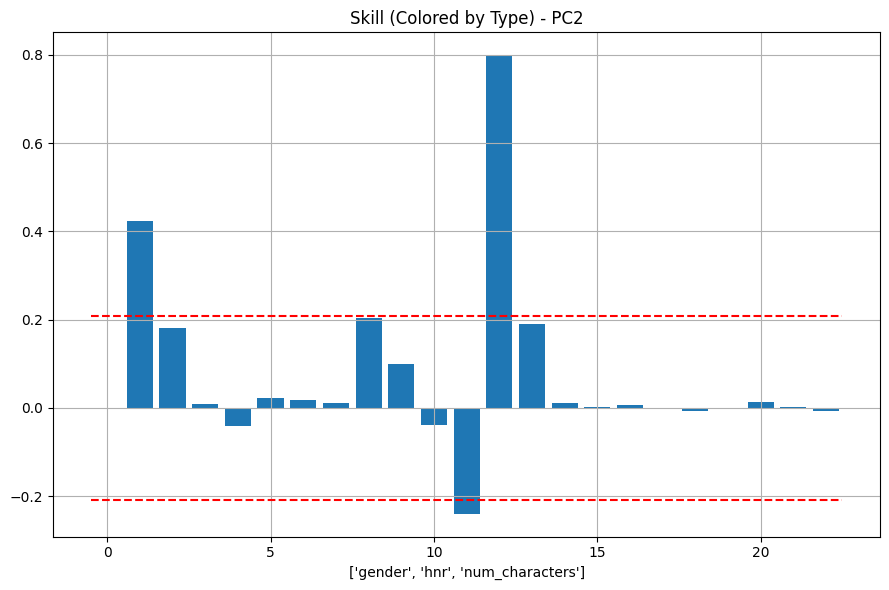


****************** PC2 **********************
HIGH-VALUED POSITIVE COMPONENTS: ['gender', 'num_characters']

HIGH-VALUED NEGATIVE COMPONENTS: ['hnr']
*********************************************



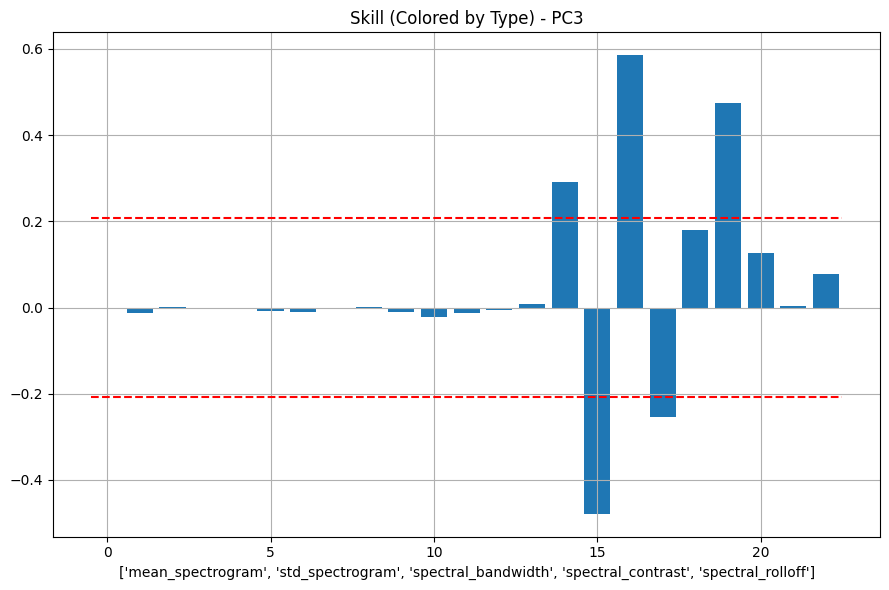


****************** PC3 **********************
HIGH-VALUED POSITIVE COMPONENTS: ['mean_spectrogram', 'spectral_bandwidth', 'spectral_rolloff']

HIGH-VALUED NEGATIVE COMPONENTS: ['std_spectrogram', 'spectral_contrast']
*********************************************



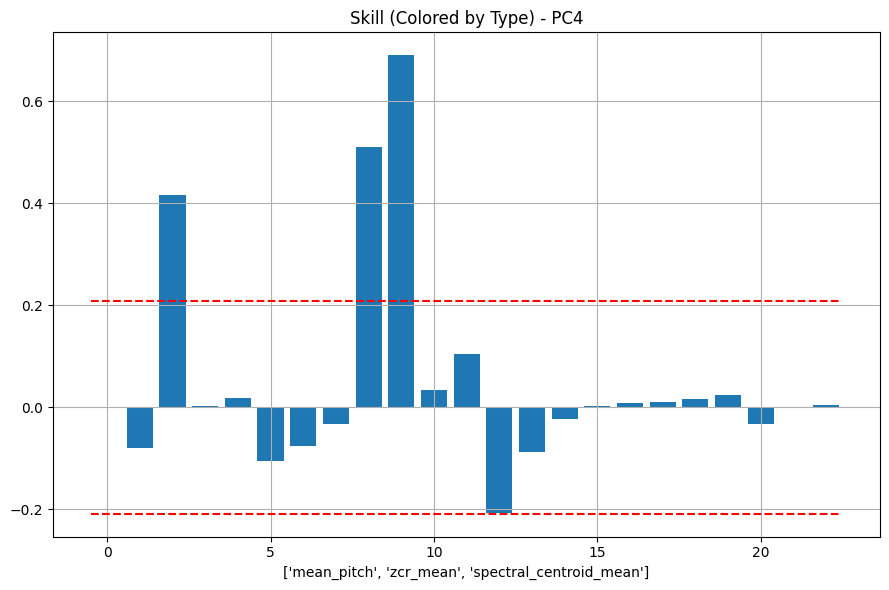


****************** PC4 **********************
HIGH-VALUED POSITIVE COMPONENTS: ['mean_pitch', 'zcr_mean', 'spectral_centroid_mean']

HIGH-VALUED NEGATIVE COMPONENTS: []
*********************************************



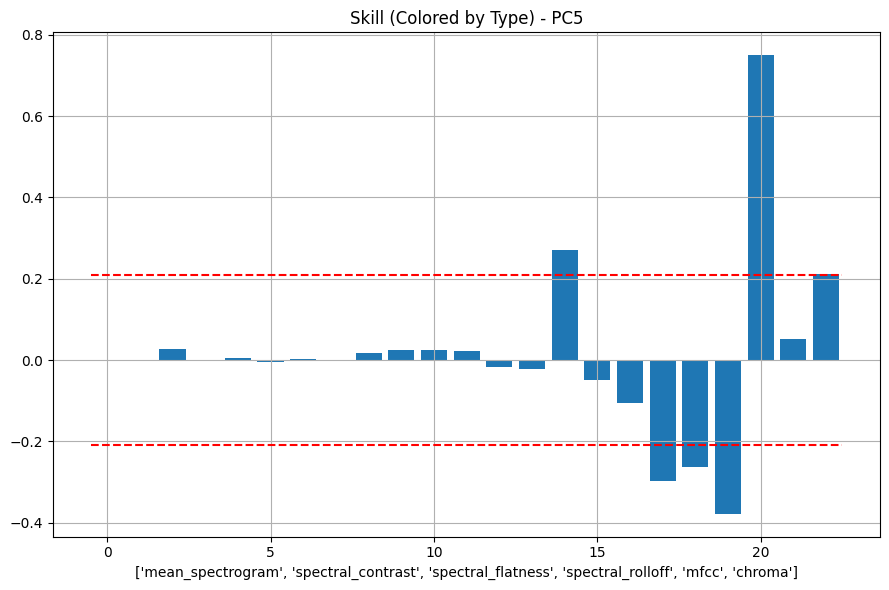


****************** PC5 **********************
HIGH-VALUED POSITIVE COMPONENTS: ['mean_spectrogram', 'mfcc', 'chroma']

HIGH-VALUED NEGATIVE COMPONENTS: ['spectral_contrast', 'spectral_flatness', 'spectral_rolloff']
*********************************************



In [37]:
# Calcolo di epsilon
eps = np.sqrt(1 / pca_std.n_features_in_)

# Lista delle colonne
cols = X_train_mm.columns.to_list()

# Ciclo per ogni componente principale
for ii in range(m):
    # Indici di componenti maggiori o uguali a epsilon (positivo e negativo)
    ind_great_pos_PCii = np.where(pca_std.components_[ii, :] >= eps)[0]
    ind_great_neg_PCii = np.where(pca_std.components_[ii, :] <= -eps)[0]
    ind_significant = np.union1d(ind_great_pos_PCii, ind_great_neg_PCii)  # Unione degli indici

    # Estrarre i label significativi
    significant_labels = [cols[idx] for idx in ind_significant]
    significant_values = pca_std.components_[ii, ind_significant]


    
    # Creazione del barplot
    plt.figure(figsize=(9, 6))
    #tupl= sorted(zip(ind_significant, significant_values), reverse=True, key=lambda x: x[1]) 
    plt.bar(np.arange(pca_std.n_features_in_), pca_std.components_[ii,:])
    plt.plot([-0.5, len(cols) - 0.5], [eps, eps], "red", linestyle="--", label=r"$\epsilon$")
    plt.plot([-0.5, len(cols) - 0.5], [-eps, -eps], "red", linestyle="--")
    plt.xlabel(significant_labels)
    plt.title(f"Skill (Colored by Type) - PC{ii + 1}")
    plt.grid()
    plt.tight_layout()
    plt.show()
    
    great_pos_PCii= [pca_std.feature_names_in_[i] for i in ind_great_pos_PCii]    
    great_neg_PCii= [pca_std.feature_names_in_[i] for i in ind_great_neg_PCii]
        
    print('')
    print(f'****************** PC{ii+1} **********************')
    print(f'HIGH-VALUED POSITIVE COMPONENTS: {great_pos_PCii}')  # <-- TODO!!
    print('')
    print(f'HIGH-VALUED NEGATIVE COMPONENTS: {great_neg_PCii}')  # <-- TODO!!
    print('*********************************************')
    print('')


In [38]:
models=[
    LinearRegression(),
    Ridge(),
    Lasso(),
    MLPRegressor(),
    # SVR(),
    RandomForestRegressor(),
    DecisionTreeRegressor(),
    RANSACRegressor(),
    HuberRegressor()
]


names=[
    'LinearRegression',
    'Ridge',
    "Lasso",
    'MLPRegressor',
    # 'SVR',
    'RandomForestRegressor',
    "DecisionTreeRegressor",
    "RANSACRegressor",
    "HuberRegressor",
]

param_grid = {
    "LinearRegression": {
        "fit_intercept": [True, False]
    },
    "Ridge": {
        "alpha": [0.01, 0.1, 1, 10],
        "solver": ['auto', 'svd', 'cholesky', 'lsqr']
    },
    "Lasso": {
        "alpha": [0.01, 0.1, 1, 10]
    },
    "MLPRegressor": {
        "hidden_layer_sizes": [(10, 10), (50, 50), (100,)],
        "activation": ['tanh', 'relu', 'logistic'],
        "alpha": [0.001, 0.01],
        "learning_rate": ['constant', 'adaptive'],
        "max_iter": [1000, 5000]
    },
    # "SVR": {
    #     "C": [0.1, 1, 10],
    #     "epsilon": [0.01, 0.1, 0.5],
    #     "kernel": ['linear', 'rbf', 'poly'],
    #     "gamma": ['scale', 'auto']
    # },
   "RandomForestRegressor": {
        "n_estimators": [100, 200],
        "max_depth": [None, 10, 20],
        "min_samples_split": [2, 5],
        "max_features": ['sqrt', 'log2', None]
    },
    "DecisionTreeRegressor": {
        "max_depth": [None, 10, 20],
        "min_samples_split": [2, 5, 10],
        "min_samples_leaf": [1, 2, 5],
        "max_features": ['sqrt', 'log2', None]
    },
    
    "RANSACRegressor": {
    "estimator": [LinearRegression(), Ridge(), Lasso()],
    "min_samples": [0.5, 0.7, 0.9],
    "residual_threshold": [1.0, 5.0, 10.0],
    "max_trials": [100, 500],
},
    "HuberRegressor": {
    "epsilon": [1.0, 1.1, 1.35],
    "alpha": [0.2, 0.3, 0.4],
    "max_iter": [100, 500, 1000],
    "tol": [1e-4, 1e-6],
    "fit_intercept": [True, False]
}

}

In [39]:
kf = KFold(n_splits=5)

RMSE=100

for model, name in zip(models, names):
    print(f"Optimizing {name}...")
    
    # Ottieni il parametro grid specifico per ogni modello
    model_param_grid = param_grid.get(name, {})

    
    # Usa GridSearchCV per la ricerca dei parametri migliori
    grid_search = GridSearchCV(model,model_param_grid, cv=kf, scoring='neg_mean_absolute_error', n_jobs=-1)
    
    # Esegui il fit sui dati
    grid_search.fit(X_train, y_train)
    
    # Ottieni i migliori parametri e la miglior performance (RMSE)
    best_params = grid_search.best_params_
    best_rmse = -grid_search.best_score_  # GridSearchCV usa una metrica negativa per l'RMSE
    
    print(f"Best parameters for {name}: {best_params}")
    print(f"Best RMSE for {name}: {best_rmse}")
    print("-" * 50)

    if best_rmse< RMSE:
        very_best_model= model
        very_best_name= name
        very_best_params = best_params
        very_best_rmse = best_rmse
        y_pred= grid_search.best_estimator_.predict(X_test)
                
print(f"best model:{very_best_name},\n parameters:{very_best_params},\n RMSE: {very_best_rmse}")

Optimizing LinearRegression...
Best parameters for LinearRegression: {'fit_intercept': True}
Best RMSE for LinearRegression: 9.03086502155532
--------------------------------------------------
Optimizing Ridge...
Best parameters for Ridge: {'alpha': 0.01, 'solver': 'svd'}
Best RMSE for Ridge: 9.03259452741492
--------------------------------------------------
Optimizing Lasso...
Best parameters for Lasso: {'alpha': 0.01}
Best RMSE for Lasso: 9.063081377976399
--------------------------------------------------
Optimizing MLPRegressor...
Best parameters for MLPRegressor: {'activation': 'relu', 'alpha': 0.001, 'hidden_layer_sizes': (10, 10), 'learning_rate': 'adaptive', 'max_iter': 1000}
Best RMSE for MLPRegressor: 9.58780639480037
--------------------------------------------------
Optimizing RandomForestRegressor...
Best parameters for RandomForestRegressor: {'max_depth': 10, 'max_features': 'sqrt', 'min_samples_split': 2, 'n_estimators': 200}
Best RMSE for RandomForestRegressor: 9.00023

c:\Users\Claudio\Desktop\Projects\venv\Lib\site-packages\sklearn\linear_model\_huber.py:343: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


In [40]:
submission = pd.DataFrame(columns=["Id","Predicted"])
submission["Id"] = complete_eval_df["Id"]
submission["Predicted"] = y_pred
submission.to_csv("final_submission.csv", index=False)

In [41]:
kf = KFold(n_splits=5)
X_test_std=pd.DataFrame(std.fit_transform(X_test), columns=X_test.columns)

RMSE=100

for model, name in zip(models, names):
    print(f"Optimizing {name}...")
    
    # Ottieni il parametro grid specifico per ogni modello
    model_param_grid = param_grid.get(name, {})

    
    # Usa GridSearchCV per la ricerca dei parametri migliori
    grid_search = GridSearchCV(model,model_param_grid, cv=kf, scoring='neg_mean_absolute_error', n_jobs=-1)
    
    # Esegui il fit sui dati
    grid_search.fit(X_train_std, y_train_std)
    
    # Ottieni i migliori parametri e la miglior performance (RMSE)
    best_params = grid_search.best_params_
    best_rmse = -grid_search.best_score_  # GridSearchCV usa una metrica negativa per l'RMSE
    
    print(f"Best parameters for {name}: {best_params}")
    print(f"Best RMSE for {name}: {best_rmse}")
    print("-" * 50)

    if best_rmse < RMSE:
        very_best_model = model
        very_best_name = name
        very_best_params = best_params
        very_best_rmse = best_rmse
        y_pred = grid_search.best_estimator_.predict(X_test_std)
                
print(f"best model:{very_best_name},\n parameters:{very_best_params},\n RMSE: {very_best_rmse}")

Optimizing LinearRegression...
Best parameters for LinearRegression: {'fit_intercept': True}
Best RMSE for LinearRegression: 9.030865021555561
--------------------------------------------------
Optimizing Ridge...
Best parameters for Ridge: {'alpha': 10, 'solver': 'auto'}
Best RMSE for Ridge: 9.024640019773278
--------------------------------------------------
Optimizing Lasso...
Best parameters for Lasso: {'alpha': 0.1}
Best RMSE for Lasso: 8.996955604523194
--------------------------------------------------
Optimizing MLPRegressor...


c:\Users\Claudio\Desktop\Projects\venv\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


Best parameters for MLPRegressor: {'activation': 'logistic', 'alpha': 0.01, 'hidden_layer_sizes': (10, 10), 'learning_rate': 'adaptive', 'max_iter': 1000}
Best RMSE for MLPRegressor: 8.949582531217882
--------------------------------------------------
Optimizing RandomForestRegressor...
Best parameters for RandomForestRegressor: {'max_depth': 10, 'max_features': 'log2', 'min_samples_split': 2, 'n_estimators': 200}
Best RMSE for RandomForestRegressor: 8.991726442589263
--------------------------------------------------
Optimizing DecisionTreeRegressor...
Best parameters for DecisionTreeRegressor: {'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 5, 'min_samples_split': 5}
Best RMSE for DecisionTreeRegressor: 9.877667437249272
--------------------------------------------------
Optimizing RANSACRegressor...
Best parameters for RANSACRegressor: {'estimator': LinearRegression(), 'max_trials': 100, 'min_samples': 0.7, 'residual_threshold': 10.0}
Best RMSE for RANSACRegressor: 8.6

In [42]:
submission_std = pd.DataFrame(columns=["Id","Predicted"])
submission_std["Id"] = complete_eval_df["Id"]
submission_std["Predicted"] = y_pred
submission_std.to_csv("final_submission_std.csv", index=False)

In [43]:
kf = KFold(n_splits=5)
X_test_mm=pd.DataFrame(mm.fit_transform(X_test), columns=X_test.columns)
RMSE=100

for model, name in zip(models, names):
    print(f"Optimizing {name}...")
    
    # Ottieni il parametro grid specifico per ogni modello
    model_param_grid = param_grid.get(name, {})

    
    # Usa GridSearchCV per la ricerca dei parametri migliori
    grid_search = GridSearchCV(model,model_param_grid, cv=kf, scoring='neg_mean_absolute_error', n_jobs=-1)
    
    # Esegui il fit sui dati
    grid_search.fit(X_train_mm, y_train_mm)
    
    # Ottieni i migliori parametri e la miglior performance (RMSE)
    best_params = grid_search.best_params_
    best_rmse = -grid_search.best_score_  # GridSearchCV usa una metrica negativa per l'RMSE
    
    print(f"Best parameters for {name}: {best_params}")
    print(f"Best RMSE for {name}: {best_rmse}")
    print("-" * 50)

    if best_rmse < RMSE:
        very_best_model = model
        very_best_name = name
        very_best_params = best_params
        very_best_rmse = best_rmse
        y_pred = grid_search.best_estimator_.predict(X_test_mm)
                
print(f"best model:{very_best_name},\n parameters:{very_best_params},\n RMSE: {very_best_rmse}")

Optimizing LinearRegression...
Best parameters for LinearRegression: {'fit_intercept': True}
Best RMSE for LinearRegression: 9.03086502155556
--------------------------------------------------
Optimizing Ridge...
Best parameters for Ridge: {'alpha': 1, 'solver': 'lsqr'}
Best RMSE for Ridge: 9.018631308709619
--------------------------------------------------
Optimizing Lasso...
Best parameters for Lasso: {'alpha': 0.01}
Best RMSE for Lasso: 9.014848425993751
--------------------------------------------------
Optimizing MLPRegressor...
Best parameters for MLPRegressor: {'activation': 'tanh', 'alpha': 0.001, 'hidden_layer_sizes': (10, 10), 'learning_rate': 'adaptive', 'max_iter': 5000}
Best RMSE for MLPRegressor: 8.855803908159753
--------------------------------------------------
Optimizing RandomForestRegressor...
Best parameters for RandomForestRegressor: {'max_depth': 10, 'max_features': 'log2', 'min_samples_split': 2, 'n_estimators': 200}
Best RMSE for RandomForestRegressor: 8.99737

In [44]:
submission_mm = pd.DataFrame(columns=["Id","Predicted"])
submission_mm["Id"] = complete_eval_df["Id"]
submission_mm["Predicted"] = y_pred
submission_mm.to_csv("final_submission_mm.csv", index=False)

In [45]:
tr = pd.DataFrame(columns=["Id","Predicted"])
tr["Id"]= submission["Id"]
tr["Predicted"]= (submission["Predicted"] + submission_std["Predicted"]+ submission_mm["Predicted"])/3
tr.to_csv("tr.csv", index=False)